# Getting information from Scopus

**Note**: This work is obtained from http://kitchingroup.cheme.cmu.edu/blog/2015/04/03/Getting-data-from-the-Scopus-API/, its author is really the author of that information. I have mainly put in a more useful way.

The access to Scopus API is restricted. First, you need a Elseview-API. You can obtain one from http://dev.elsevier.com/myapikey.html. 

In my case, because I have access by a Proxy (and using a VPN, but it is transparent) I also need a PROXY_URL. That both information are not in the repository because they are personal and private. You should create your own my_scopus.py file to run that code without changes.

In [1]:
import requests
import json
from my_scopus import MY_API_KEY, PROXY_URL, MY_AUTHOR_ID

First, we define a function to access to the information

In [2]:
def scopus_get_info_api(url, proxy=PROXY_URL,*,json=True):
    """
    Returns the information obtained by the Elseview API
    """
    proxies = {
        "http": PROXY_URL
    }

    resp = requests.get("http://api.elsevier.com/content/" +url,
                    headers={'Accept':'application/json',
                             'X-ELS-APIKey': MY_API_KEY}, proxies=proxies)
    if json:
        return resp.json()
    else:
        return resp.text.encode('utf-8')

Then, a util function to show the information

In [3]:
def print_json(resp_json):
    print(json.dumps(resp_json,
                 sort_keys=True,
                 indent=4, separators=(',', ': ')))

A function that return the information of the author.

## Obtaining Author info

In [4]:
def scopus_get_author(author_id):
    msg = "author?author_id={}&view=metrics".format(author_id)
    resp = scopus_get_info_api(msg)
    return resp['author-retrieval-response'][0]

Example, to obtain my h-index

In [5]:
author_info = scopus_get_author(MY_AUTHOR_ID)
print_json(author_info)
h_index = author_info['h-index']
print("My automatic h_index is {}".format(h_index))

{
    "@_fa": "true",
    "@status": "found",
    "coauthor-count": "26",
    "coredata": {
        "citation-count": "1235",
        "cited-by-count": "1041",
        "dc:identifier": "AUTHOR_ID:22135567700",
        "document-count": "32",
        "prism:url": "http://api.elsevier.com/content/author/author_id/22135567700"
    },
    "h-index": "10"
}
My automatic h_index is 10


## Obtaining list of references

Now, we are going to extract the list of published papers.

In [6]:
def scopus_search_list(query, field, max=100):
    msg = "search/scopus?query={}&nofield={}&count={}".format(query, field, max)
    resp = scopus_get_info_api(msg)['search-results']
    list = []
    
    if resp['entry']:
        list = resp['entry']
        
    return list

In [7]:
def scopus_papers_from_author(author_id, *, max=100):
    """
    Return the list of papers from the author
    """
    query = "AU-ID({})".format(author_id)
    field = "dc:identifier"
    
    list = scopus_search_list(query, field, max)
    #print_json(list)
    
    def get_type(code):
        if code in ['ar','re', 'ed', 'ip']:
            return 'article'
        elif code == 'cp':
            return 'congress'
        else:
            return code
        
    return [{'id': info['dc:identifier'], 
             'title': info['dc:title'], 
             'url': info['prism:url'], 
            'citations': int(info['citedby-count']), 
            'type': get_type(info['subtype']), 
             'year': info['prism:coverDate'][:4], 
            'journal': info['prism:publicationName']} for info in list]

In [8]:
papers = scopus_papers_from_author(MY_AUTHOR_ID)
print('{} papers'.format(len(papers)))

33 papers


## Translate to pandas

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame.from_dict(papers)
print(df.head())

   citations                     id  \
0          0  SCOPUS_ID:84930999593   
1          2  SCOPUS_ID:84922590736   
2          0  SCOPUS_ID:84919727129   
3          4  SCOPUS_ID:84892553248   
4          0  SCOPUS_ID:84908587588   

                                             journal  \
0  International Journal of Computational Intelli...   
1                               Information Sciences   
2                     Applied Soft Computing Journal   
3                               Information Sciences   
4  Proceedings of the 2014 IEEE Congress on Evolu...   

                                               title      type  \
0  A Walk into Metaheuristics for Engineering Opt...   article   
1  A high performance memetic algorithm for extre...   article   
2  Performance evaluation of automatically tuned ...   article   
3  Region based memetic algorithm for real-parame...   article   
4  Influence of regions on the memetic algorithm ...  congress   

                               

### Ploting results

In [11]:
papers_journal = df[df['type']=='article']
citations = papers_journal.groupby(['year']).sum()

In [12]:
%pylab inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


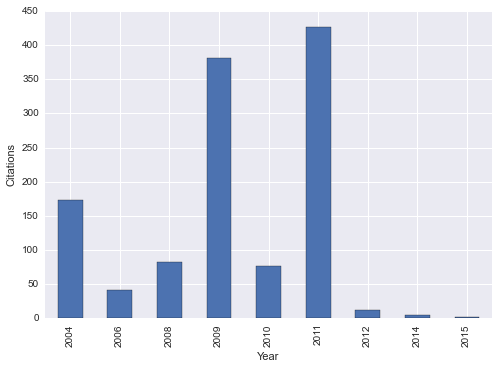

In [13]:
ax = citations.plot(kind='bar', legend=None)
ax.set_xlabel('Year')
ax.set_ylabel('Citations')

### Get complete reference of a paper

In [14]:
def get_scopus_info(SCOPUS_ID):
    url = ("abstract/scopus_id/"
          + SCOPUS_ID
          + "?field=authors,title,publicationName,volume,issueIdentifier,"
          + "prism:pageRange,coverDate,article-number,doi,citedby-count,prism:aggregationType")
    
    resp = scopus_get_info_api(url, json=True)
    results = resp['abstracts-retrieval-response']
    authors_info = results['authors']
    info = results['coredata']

    fstring = '{authors}, {title}, {journal}, {volume}, {articlenum}, ({date}). {doi} (cited {cites} times).\n'
    return fstring.format(authors=', '.join([au['ce:indexed-name'] for au in authors_info['author']]),
                          title=info['dc:title'],
                          journal=info['prism:publicationName'],
                          volume=info.get('prism:volume') or 1,
                          articlenum=info.get('prism:pageRange') or
                            info.get('article-number'),
                          date=info['prism:coverDate'],
                          doi='doi:' +(info.get('prism:doi') or 'NA'),
                        cites=int(info['citedby-count']))

df_lasts = df[df['year']=='2015']

for id in df.sort(['citations'], ascending=[0])['id']:
    #print("id: '{}'".format(id))
    print(get_scopus_info(id))

Garcia S., Molina D., Lozano M., Herrera F., A study on the use of non-parametric tests for analyzing the evolutionary algorithms' behaviour: A case study on the CEC'2005 Special Session on Real Parameter Optimization, Journal of Heuristics, 15, 617-644, (2009-12-01). doi:10.1007/s10732-008-9080-4 (cited 381 times).

Derrac J., Garcia S., Molina D., Herrera F., A practical tutorial on the use of nonparametric statistical tests as a methodology for comparing evolutionary and swarm intelligence algorithms, Swarm and Evolutionary Computation, 1, 3-18, (2011-03-01). doi:10.1016/j.swevo.2011.02.002 (cited 346 times).

Lozano M., Herrera F., Krasnogor N., Molina D., Real-coded memetic algorithms with crossover hill-climbing, Evolutionary Computation, 12, 273-302, (2004-09-01). doi:10.1162/1063656041774983 (cited 173 times).

Garcia-Martinez C., Lozano M., Herrera F., Molina D., Sanchez A.M., Global and local real-coded genetic algorithms based on parent-centric crossover operators, European 

## List of journals in which I have published

In [29]:
revistas = sorted(set(papers_journal['journal']))
for revista in revistas:
    print(revista)

Applied Soft Computing Journal
European Journal of Operational Research
Evolutionary Computation
Expert Systems with Applications
IEEE Transactions on Neural Networks and Learning Systems
Information Sciences
International Journal of Computational Intelligence Systems
Journal of Heuristics
Soft Computing
Swarm and Evolutionary Computation
